# Cyber Bullying

In [1]:
from typing import List
import nltk
import os
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from enchant.checker import SpellChecker
# from nltk.stem import WordNetLemmatizer
import swifter
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Preprocess

In [7]:

def merge_datasets(data_path='./Data/Source1') -> pd.DataFrame:
    df = pd.DataFrame()
    for filename in os.listdir(data_path):
        df1 = pd.read_csv(f'{data_path}/{filename}')
        df1 = df1[['Text', 'oh_label']]
        df = pd.concat([df, df1], axis=0)
    df["Text"] = df["Text"].astype(str)
    df = df.reset_index(drop=True)
    print("database merged successfully!")
    return df


def add_punctuation_stopwords_curse_features(df: pd.DataFrame) -> pd.DataFrame:
    def get_curses():
        lst = []
        with open("english_curse.csv") as curses_file:
            for curse in curses_file.readlines():
                lst.append(curse.replace("\n", ""))
        return lst

    curses = get_curses()
    features = list(string.punctuation) + list(stopwords.words('english')) + curses
    # new_features_cols = []
    for ch in features:
        df[ch] = df['Text'].astype(str).apply(lambda s: s.count(ch) / len(s))
    print("add_punctuation_and_stopwords_features successfully!")
    return df


def add_count_misspell_feature(df: pd.DataFrame) -> pd.DataFrame:
    def helper(data: str) -> float:
        spell = SpellChecker("en_US", data)
        counter = 0
        for _ in spell:
            counter += 1
        return counter / len(data)

    misspell_count = df["Text"].swifter.apply(helper).rename("misspell_count")
    df = pd.concat([df, misspell_count], axis=1)
    print("add_count_misspell_feature successfully!")
    return df


def add_avg_word_len_feature(df: pd.DataFrame) -> pd.DataFrame:
    avg_word_len = df["Text"].astype(str).swifter.apply(
        lambda s: pd.Series(nltk.word_tokenize(s)).map(len).mean()).rename("avg_word_len")
    df = pd.concat([df, avg_word_len], axis=1)
    print("add_avg_word_len_feature successfully!")
    return df


def add_avg_sentence_len_feature(df: pd.DataFrame) -> pd.DataFrame:
    sentence_count = df["Text"].astype(str).swifter.apply(
        lambda text: pd.Series(nltk.sent_tokenize(text)).map(lambda sent: len(nltk.word_tokenize(sent))).mean()) \
        .rename("sentence_count")

    df = pd.concat([df, sentence_count], axis=1)
    print("add_avg_sentence_len_feature successfully!")
    return df


def add_uppercase_count_feature(df: pd.DataFrame) -> pd.DataFrame:
    uppercase_count = df['Text'].str.findall(r'[A-Z]').str.len().rename("uppercase_count") / df["Text"].str.len()
    df = pd.concat([df, uppercase_count], axis=1)
    print("add_uppercase_count_feature successfully!")
    return df


def add_pos_features(df: pd.DataFrame) -> pd.DataFrame:
    def group_pos(tag):
        groups = {"noun": ['NN', 'NNS', 'NNP', 'NNPS'], "verb": ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
                  "adverb": ['RB', 'RBR', 'RBS'], "adjective": ['JJ', 'JJR', 'JJS']}
        for key, group in groups.items():
            if tag in group:
                return key
        return None

    features = df["Text"].swifter.apply(lambda s: pd.Series([x[1] for x in nltk.pos_tag(nltk.word_tokenize(s))]).
                                        apply(group_pos).value_counts(normalize=True).copy())
    print("add_pos_features successfully!")
    features = features.fillna(0)
    return pd.concat([df, features], axis=1)


def to_one_hot_rep(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    cv = CountVectorizer()
    data_cv = cv.fit_transform(df[col_name])
    data_cv = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_cv["oh_label"] = df["oh_label"]
    return data_cv


def bug_fix(df: pd.DataFrame, ignored_columns: List[str]) -> pd.DataFrame:
    print("loaded!")
    df["uppercase_count"] /= df["Text"].str.len()
    print("fix broken col")
    X_df = df.drop(ignored_columns, axis=1)
    normalized_X_df = (X_df - X_df.mean()) / X_df.std()
    df = pd.concat([df[ignored_columns], normalized_X_df], axis=1)
    print("normalized")
    return df


def preprocess(train_part=0.7, use_cache=True, debug=True,data_path="./Data") -> (
        np.ndarray, np.ndarray, np.ndarray, np.ndarray, pd.DataFrame):
    print("preprocess...")
    cleaned_output_path = f"{data_path}/cleaned-debug.csv" if debug else f"{data_path}/cleaned.csv"
    label_name = "oh_label"
    ignored_columns = ["Text", label_name]
    if use_cache and os.path.isfile(cleaned_output_path):
        df = pd.read_csv(cleaned_output_path, index_col=0)
        # df = bug_fix(df,label_name)
    else:
        df = merge_datasets()
        df = add_pos_features(df)
        df = add_punctuation_stopwords_curse_features(df)
        df = add_uppercase_count_feature(df)
        df = add_avg_word_len_feature(df)
        df = add_count_misspell_feature(df)
        df = add_avg_sentence_len_feature(df)
        # df["Text"] = df["Text"].apply(process_row)
        # df = to_one_hot_rep(df)
        if not debug:
            df.to_csv(cleaned_output_path)
        print("Saved")
    df = df.fillna(0)
    x = df.drop(ignored_columns, axis=1).values
    y = df[label_name].values
    num_rows = x.shape[0]
    mask_train = np.zeros(num_rows, dtype=bool)
    mask_train[np.random.choice(num_rows, int(num_rows * train_part), replace=False)] = True
    print(mask_train.shape, x.shape, y.shape)
    return x[mask_train, :], y[mask_train], x[~mask_train, :], y[~mask_train], df


## Model Implementation
using tensorflow version 1

In [3]:
eps = 1e-12


def save_loss(data: list, filename: str):
    with open(filename, 'w') as f:
        for item in data:
            f.write("%s\n" % item)


class LogisticRegression:
    def __init__(self, X_train: np.ndarray, y_train: np.ndarray, num_iter=5000, learning_rate=0.001, batch_size=100,
                 print_step=1000):
        """
        weighted logistic regression using cross entropy loss function
        :param num_iter:
        :param batch_size: -1 means all
        """
        self.losses = []
        self.sess = tf.Session()
        features = X_train.shape[1]
        self.x = tf.placeholder(tf.float64, [None, features])
        y_train_variable = tf.placeholder(tf.float64, [None, 1])
        W = tf.Variable(tf.random.truncated_normal([features, 1],dtype=tf.float64))
        b = tf.Variable(tf.random.truncated_normal([1],dtype=tf.float64))
        self.y = 1 / (1.0 + tf.exp(-(tf.matmul(self.x, W) + b)))
        loss = tf.reduce_mean(-(20 * y_train_variable * tf.log(self.y + eps) + 80 * (1 - y_train_variable) * tf.log(
            1 - self.y + eps)))  # cross entropy
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  # TODO: check other optimizers
        self.sess.run(tf.global_variables_initializer())
        np.random.shuffle(X_train)
        rows_num = X_train.shape[0]
        for i in range(0, num_iter * rows_num):
            counter_step = i % (rows_num // batch_size)
            X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            if i % print_step == 0:
                print(f"iteration {i}: loss value is: {loss_value}")
                self.losses.append(loss_value)
        save_loss(self.losses, filename="LogisticRegression.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


class MLP:
    """
    multi level perceptron implementation using tensorflow version 1
    """

    def __init__(self, X_train: np.ndarray, y_train, layers_sizes: List[int], learning_rate=0.001, num_iter=5000,
                 batch_size=100,
                 print_step=100):
        """
        Feed Foreword Neural network using Batch gradient decent optimizer
        :param layers_sizes: len of this list need to be greater than 1
        :param num_iter:
        :param print_step: print loss value every print_step echos
        """
        self.sess = tf.Session()
        self.losses = []
        rows_num, features = X_train.shape[0], X_train.shape[1]
        self.x = tf.placeholder(tf.float32, [None, features])
        y_train_variable = tf.placeholder(tf.float32, [None, 1])
        layers_sizes = [features] + layers_sizes.copy() + [1]
        W, b = [], []
        for i, layer_size in enumerate(layers_sizes[1:]):
            W.append(tf.Variable(tf.zeros([layers_sizes[i], layer_size])))  # random.truncated_normal
            b.append(tf.Variable(tf.zeros([layer_size])))
        # ff
        prev_output = tf.nn.relu(tf.matmul(self.x, W[0]) + b[0])
        for layer_w, layer_b in zip(W[1:-1], b[1:-1]):
            prev_output = tf.nn.relu(1 / (1.0 + tf.exp(-(tf.add(tf.matmul(prev_output, layer_w), layer_b)))))
        self.y = tf.nn.sigmoid(1 / (1.0 + tf.exp(-(tf.add(tf.matmul(prev_output, W[-1]), b[-1])))))
        loss = tf.reduce_mean(-(y_train_variable * tf.log(self.y + eps) + (1 - y_train_variable) * tf.log(
            1 - self.y + eps)))  # cross entropy
        update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)  # TODO: check other optimizers
        self.sess.run(tf.global_variables_initializer())
        np.random.shuffle(X_train)
        for i in range(0, num_iter * rows_num):
            counter_step = i % (rows_num // batch_size)
            X_batch = X_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = y_train[counter_step * batch_size:min((counter_step + 1) * batch_size, rows_num)]
            Y_batch = Y_batch.reshape((Y_batch.size, 1))
            self.sess.run(update, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            loss_value = self.sess.run(loss, feed_dict={self.x: X_batch, y_train_variable: Y_batch})
            if i % print_step == 0:
                print(f"iteration {i}: loss value is: {loss_value}")
                self.losses.append(loss_value)
        save_loss(self.losses,filename="MLP.txt")

    def predict(self, X_test, thr=0.5):
        predictions = self.sess.run(self.y, feed_dict={self.x: X_test})
        predictions[predictions >= thr] = 1
        predictions[predictions < thr] = 0
        return predictions


## Exploration

In [10]:
x_train, y_train, x_test, y_test, df = preprocess(use_cache=True, debug=False,data_path="../Data/")
df.head()

preprocess...
(5000,) (5000, 595) (5000,)


,Text,oh_label,adjective,adverb,noun,verb,!,"""",#,$,...,xx,xxx,yaoi,yellow showers,yiffy,zoophilia,ðŸ–•,uppercase_count,avg_word_len,misspell_count
17290,"== Broken links == Sure, I'll try my best to...",0.0,0.322876,0.616228,-0.393145,-0.086298,0.153123,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.160139,-0.148059,-0.671879
262366,I don't have an entire range.. you do your b...,1.0,-0.215881,-0.180974,-0.207756,0.507017,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.130488,-0.060896,0.106400
138126,ADDENDUM: I have just sent a note to the Archi...,0.0,-1.334839,0.052988,0.133528,0.648783,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,0.274112,-0.101311,-0.671879
332862,` == The Ouse == You reverted my edit with a...,0.0,0.420389,-0.887445,0.189293,0.037245,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.117602,-0.155813,-0.671879
301315,"==The cross or Calvin's image?== Come on, t...",1.0,1.716864,0.478372,-0.125021,-1.219946,-0.141856,-0.122218,-0.175769,-0.031636,...,-0.025241,-0.013459,-0.004278,0.0,0.0,-0.003293,0.0,-0.177148,-0.158368,-0.671879


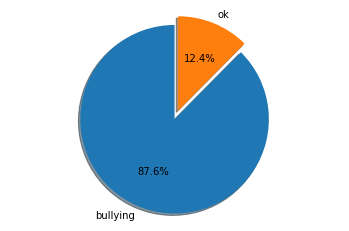

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


fig1, ax1 = plt.subplots()
ax1.pie(df["oh_label"].value_counts(), explode=(0, 0.1), labels=["bullying","ok"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

<AxesSubplot:>

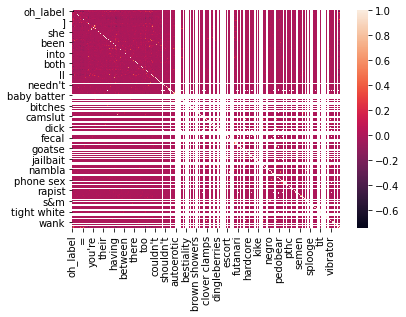

In [19]:
sns.heatmap(df.corr())

## Models

In [5]:
from sklearn.metrics import classification_report

In [ ]:
logistic = models.LogisticRegression(x_train,y_train,num_iter=5000)
predictions = logistic.predict(x_test)
print(classification_report(y_test, predictions,zero_division=0))

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)
print(classification_report(y_test,predictions,zero_division=0))

In [ ]:
mlp = models.MLP(x_train, y_train, [500, 400, 350,200,100],num_iter=5000)
mlp_predictions = mlp.predict(x_test)
print(classification_report(y_test, mlp_predictions, zero_division=0))

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Text","oh_label"],axis=1), df["oh_label"], test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [55]:
import xgboost as xgb
param = {"learning_rate":0.05, "max_depth":8,"min_child_weight":1,"gamma":0,"subsample":0.7,
    "objective":'binary:logistic', "scale_pos_weight":1,"seed":93,"eval_metric":"logloss"}
# "colsample_bytree":0.8# evals=evals, early_stopping_rounds=10
dtrain = xgb.DMatrix(x_train.values, label=y_train.values)
deval = xgb.DMatrix(x_val.values, label=y_val.values)
evallist = [(deval, 'eval'), (dtrain, 'train')]
num_round = 1000
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-logloss:0.66141	train-logloss:0.65904
[1]	eval-logloss:0.63178	train-logloss:0.62749
[2]	eval-logloss:0.60506	train-logloss:0.59890
[3]	eval-logloss:0.58122	train-logloss:0.57292
[4]	eval-logloss:0.55873	train-logloss:0.54831
[5]	eval-logloss:0.53879	train-logloss:0.52545
[6]	eval-logloss:0.52046	train-logloss:0.50408
[7]	eval-logloss:0.50345	train-logloss:0.48489
[8]	eval-logloss:0.48834	train-logloss:0.46666
[9]	eval-logloss:0.47369	train-logloss:0.44934
[10]	eval-logloss:0.46036	train-logloss:0.43371
[11]	eval-logloss:0.44736	train-logloss:0.41902
[12]	eval-logloss:0.43527	train-logloss:0.40597
[13]	eval-logloss:0.42411	train-logloss:0.39269
[14]	eval-logloss:0.41432	train-logloss:0.38060
[15]	eval-logloss:0.40463	train-logloss:0.36913
[16]	eval-logloss:0.39583	train-logloss:0.35763
[17]	eval-logloss:0.38751	train-logloss:0.34722
[18]	eval-logloss:0.37981	train-logloss:0.33745
[19]	eval-logloss:0.37276	train-logloss:0.32844
[20]	eval-logloss:0.36552	train-logloss:0.31902
[2

[170]	eval-logloss:0.27370	train-logloss:0.05471
[171]	eval-logloss:0.27382	train-logloss:0.05437
[172]	eval-logloss:0.27418	train-logloss:0.05396
[173]	eval-logloss:0.27448	train-logloss:0.05356
[174]	eval-logloss:0.27429	train-logloss:0.05326
[175]	eval-logloss:0.27469	train-logloss:0.05293
[176]	eval-logloss:0.27503	train-logloss:0.05259
[177]	eval-logloss:0.27500	train-logloss:0.05209
[178]	eval-logloss:0.27525	train-logloss:0.05174
[179]	eval-logloss:0.27552	train-logloss:0.05139
[180]	eval-logloss:0.27537	train-logloss:0.05108
[181]	eval-logloss:0.27549	train-logloss:0.05083
[182]	eval-logloss:0.27541	train-logloss:0.05062
[183]	eval-logloss:0.27497	train-logloss:0.05015
[184]	eval-logloss:0.27505	train-logloss:0.04984
[185]	eval-logloss:0.27498	train-logloss:0.04963
[186]	eval-logloss:0.27485	train-logloss:0.04918
[187]	eval-logloss:0.27531	train-logloss:0.04893
[188]	eval-logloss:0.27499	train-logloss:0.04871
[189]	eval-logloss:0.27555	train-logloss:0.04832
[190]	eval-logloss:0

[338]	eval-logloss:0.30129	train-logloss:0.02218
[339]	eval-logloss:0.30166	train-logloss:0.02208
[340]	eval-logloss:0.30190	train-logloss:0.02198
[341]	eval-logloss:0.30238	train-logloss:0.02190
[342]	eval-logloss:0.30212	train-logloss:0.02184
[343]	eval-logloss:0.30219	train-logloss:0.02174
[344]	eval-logloss:0.30261	train-logloss:0.02163
[345]	eval-logloss:0.30263	train-logloss:0.02151
[346]	eval-logloss:0.30281	train-logloss:0.02144
[347]	eval-logloss:0.30290	train-logloss:0.02133
[348]	eval-logloss:0.30310	train-logloss:0.02122
[349]	eval-logloss:0.30353	train-logloss:0.02112
[350]	eval-logloss:0.30381	train-logloss:0.02103
[351]	eval-logloss:0.30402	train-logloss:0.02093
[352]	eval-logloss:0.30388	train-logloss:0.02085
[353]	eval-logloss:0.30404	train-logloss:0.02079
[354]	eval-logloss:0.30457	train-logloss:0.02070
[355]	eval-logloss:0.30455	train-logloss:0.02064
[356]	eval-logloss:0.30466	train-logloss:0.02055
[357]	eval-logloss:0.30486	train-logloss:0.02047
[358]	eval-logloss:0

[506]	eval-logloss:0.32604	train-logloss:0.01287
[507]	eval-logloss:0.32595	train-logloss:0.01284
[508]	eval-logloss:0.32628	train-logloss:0.01280
[509]	eval-logloss:0.32655	train-logloss:0.01276
[510]	eval-logloss:0.32652	train-logloss:0.01273
[511]	eval-logloss:0.32656	train-logloss:0.01271
[512]	eval-logloss:0.32667	train-logloss:0.01268
[513]	eval-logloss:0.32660	train-logloss:0.01265
[514]	eval-logloss:0.32678	train-logloss:0.01262
[515]	eval-logloss:0.32668	train-logloss:0.01259
[516]	eval-logloss:0.32673	train-logloss:0.01255
[517]	eval-logloss:0.32670	train-logloss:0.01252
[518]	eval-logloss:0.32649	train-logloss:0.01249
[519]	eval-logloss:0.32667	train-logloss:0.01247
[520]	eval-logloss:0.32695	train-logloss:0.01245
[521]	eval-logloss:0.32691	train-logloss:0.01241
[522]	eval-logloss:0.32720	train-logloss:0.01238
[523]	eval-logloss:0.32756	train-logloss:0.01236
[524]	eval-logloss:0.32754	train-logloss:0.01233
[525]	eval-logloss:0.32776	train-logloss:0.01230
[526]	eval-logloss:0

[674]	eval-logloss:0.34117	train-logloss:0.00914
[675]	eval-logloss:0.34107	train-logloss:0.00913
[676]	eval-logloss:0.34121	train-logloss:0.00911
[677]	eval-logloss:0.34153	train-logloss:0.00910
[678]	eval-logloss:0.34156	train-logloss:0.00908
[679]	eval-logloss:0.34144	train-logloss:0.00907
[680]	eval-logloss:0.34121	train-logloss:0.00906
[681]	eval-logloss:0.34137	train-logloss:0.00904
[682]	eval-logloss:0.34138	train-logloss:0.00902
[683]	eval-logloss:0.34135	train-logloss:0.00901
[684]	eval-logloss:0.34150	train-logloss:0.00900
[685]	eval-logloss:0.34126	train-logloss:0.00899
[686]	eval-logloss:0.34141	train-logloss:0.00897
[687]	eval-logloss:0.34157	train-logloss:0.00896
[688]	eval-logloss:0.34163	train-logloss:0.00894
[689]	eval-logloss:0.34155	train-logloss:0.00893
[690]	eval-logloss:0.34161	train-logloss:0.00892
[691]	eval-logloss:0.34179	train-logloss:0.00890
[692]	eval-logloss:0.34179	train-logloss:0.00889
[693]	eval-logloss:0.34181	train-logloss:0.00887
[694]	eval-logloss:0

[842]	eval-logloss:0.35298	train-logloss:0.00730
[843]	eval-logloss:0.35309	train-logloss:0.00729
[844]	eval-logloss:0.35323	train-logloss:0.00728
[845]	eval-logloss:0.35322	train-logloss:0.00727
[846]	eval-logloss:0.35320	train-logloss:0.00726
[847]	eval-logloss:0.35319	train-logloss:0.00725
[848]	eval-logloss:0.35316	train-logloss:0.00724
[849]	eval-logloss:0.35315	train-logloss:0.00723
[850]	eval-logloss:0.35311	train-logloss:0.00723
[851]	eval-logloss:0.35325	train-logloss:0.00722
[852]	eval-logloss:0.35355	train-logloss:0.00721
[853]	eval-logloss:0.35378	train-logloss:0.00720
[854]	eval-logloss:0.35390	train-logloss:0.00719
[855]	eval-logloss:0.35401	train-logloss:0.00718
[856]	eval-logloss:0.35396	train-logloss:0.00717
[857]	eval-logloss:0.35407	train-logloss:0.00716
[858]	eval-logloss:0.35416	train-logloss:0.00716
[859]	eval-logloss:0.35432	train-logloss:0.00715
[860]	eval-logloss:0.35436	train-logloss:0.00714
[861]	eval-logloss:0.35450	train-logloss:0.00713
[862]	eval-logloss:0

In [58]:
d_test = xgb.DMatrix(x_test.values)
pred = bst.predict(d_test)
pred[pred>0.5] = 1
pred[pred<=0.5] = 0
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94       882
         1.0       0.69      0.25      0.36       118

    accuracy                           0.90      1000
   macro avg       0.80      0.62      0.65      1000
weighted avg       0.88      0.90      0.88      1000



In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
torch.cuda.is_available()

False

In [ ]:
# https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

## RNN Models